# Data assimilation in neXtSIM-DG with NEDAS
Authors: Yue (Michael) Ying (NERSC), Ali Aydogdu (CMCC), Yumeng Chen (U. Reading)

Observing System Simulation Experiment (OSSE)

## Environment and configuration

In [1]:
import os
import sys

import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean
from NEDAS.utils.graphics import add_colorbar, adjust_ax_size

##for display of plots with sliders
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

from NEDAS.config import Config
from NEDAS.schemes import get_analysis_scheme


In [2]:
# check how many CPUs are available on your system
os.cpu_count()

8

In [3]:
# Configuration
config_file = "/home/nextsim-workshop/notebooks-nextsim-workshop2025/assimilation/config.yml"

c = Config(config_file=config_file,
           nproc=6, ## number of processors; set according to your cpu count
           nens=6,  ## ensemble size
           debug=False,
          )

In [4]:
ncycle = int((c.time_end - c.time_start) / (c.cycle_period*timedelta(hours=1)))


In [5]:
model = c.models['nextsim.dg']

model

In [6]:
# Analysis scheme: offline filter
scheme = get_analysis_scheme(c)

scheme

In [7]:
# To run the analysis, you can run: 
# scheme(c)

# or in bash command line:
# python -m NEDAS -c config.yml

## Truth run

In [17]:
#you can skip this, truth run is ready in data already

run_dir = os.path.join(model.truth_dir, 'run', 'ens_01')
os.system("mkdir -p "+run_dir)

icbc_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/icbc"
init_file = os.path.join(icbc_dir, f"restart{c.time_start:%Y-%m-%dT%H:%M:%SZ}.nc")
atmos_forcing_file = os.path.join(icbc_dir, "25km_NH.ERA5.nc")
ocean_forcing_file = os.path.join(icbc_dir, "25km_NH.TOPAZ4.nc")
for file in [init_file, atmos_forcing_file, ocean_forcing_file]:
    os.system(f"ln -fs {file} {run_dir}/.")

c.time = c.time_start
while c.time < c.time_end:
    file = f"restart{c.time:%Y-%m-%dT%H:%M:%SZ}.bin"
    next_file = f"restart{c.next_time:%Y-%m-%dT%H:%M:%SZ}.bin"
    print(f"Running the model from condition {file} to reach {next_file}")

    model.run(path=os.path.join(model.truth_dir, 'run'),
              member=0,
              time=c.time,
              forecast_period=c.cycle_period,
              time_start=c.time_start,
              time_end=c.time_end,
              debug=c.debug,
              **c.job_submit)

    c.time = c.next_time

# clean up
os.system(f"mv {run_dir}/restart*.nc {model.truth_dir}/.")
tmp_dir = os.path.join(model.truth_dir, 'run')
os.system(f"rm -rf {tmp_dir}")
print("done.")

Running the model from condition restart2010-01-01T00:00:00Z.bin to reach restart2010-01-01T06:00:00Z.bin
Running the model from condition restart2010-01-01T06:00:00Z.bin to reach restart2010-01-01T12:00:00Z.bin
Running the model from condition restart2010-01-01T12:00:00Z.bin to reach restart2010-01-01T18:00:00Z.bin
Running the model from condition restart2010-01-01T18:00:00Z.bin to reach restart2010-01-02T00:00:00Z.bin
Running the model from condition restart2010-01-02T00:00:00Z.bin to reach restart2010-01-02T06:00:00Z.bin
Running the model from condition restart2010-01-02T06:00:00Z.bin to reach restart2010-01-02T12:00:00Z.bin
Running the model from condition restart2010-01-02T12:00:00Z.bin to reach restart2010-01-02T18:00:00Z.bin
Running the model from condition restart2010-01-02T18:00:00Z.bin to reach restart2010-01-03T00:00:00Z.bin
Running the model from condition restart2010-01-03T00:00:00Z.bin to reach restart2010-01-03T06:00:00Z.bin
Running the model from condition restart2010-0

In [8]:
# list of variables in nextsim.dg model
model.variables.keys()

dict_keys(['seaice_conc_dg', 'seaice_thick_dg', 'seaice_damage', 'snow_thick', 'seaice_temp_k', 'seaice_velocity', 'seaice_conc', 'seaice_thick', 'atmos_surf_velocity', 'atmos_surf_press', 'atmos_surf_temp', 'atmos_surf_dewpoint', 'atmos_down_shortwave', 'atmos_down_longwave', 'ocean_surf_velocity', 'ocean_surf_temp', 'ocean_surf_salinity', 'ocean_mixl_depth'])

In [9]:
# pick a variable to plot, sea ice concentration for example.
vname = 'seaice_conc'
vmin = 0
vmax = 1
cmap = cmocean.cm.ice


In [ ]:
vname = 'seaice_thick'
vmin = 0
vmax = 3
cmap = 'viridis'


In [12]:
for n in range(ncycle):
    time = c.time_start + n * c.cycle_period * timedelta(hours=1)
    fld = model.read_var(path=model.truth_dir, time=time, name=vname)
    if n==0:
        model.grid.mask = np.isnan(fld)
    else:
        fld[model.grid.mask] = np.nan

    fig, ax = plt.subplots(1,1,figsize=(6,4.5))
    model.grid.plot_field(ax, fld, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax, cmap, vmin, vmax)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"{vname} {time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()


In [13]:
# view figures
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=ncycle-1,
    step=1,
    description='Cycle:',
    continuous_update=False
)
output = widgets.Output()

def update_plot(n):
    with output:
        clear_output(wait=True)
        time = c.time_start + n * c.cycle_period * timedelta(hours=1)
        display(Image(filename=os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, n=slider)
display(output)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cycle:', max=11), Output()), _d…

Output()

## Ensemble generation

Check nextsim-config.yml perturb section for parameters

You can try to change:

- `amp` (standard deviation of perturbations)
- `hcorr` (horizontal correlation length, in meters)
- `tcorr` (temporal correlation length, in hours)

By default the atmospheric forcing (wind) is perturbed using Evensen 1994 approach to generate ensemble members

In [75]:
##you can skip this
# generate ensemble by perturbed runs, test the effect of changing parameters
def generate_init_ens():
    c.time = c.time_start
    os.system("mkdir -p "+c.cycle_dir(c.time))
    # preprocessing, linking files and perturbing boundary forcing files
    scheme.run_step(c, 'preprocess', mpi=False)
    # run ensemble forecast step
    scheme.run_step(c, 'ensemble_forecast', mpi=False)

generate_init_ens()


RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/icbc
..................................................| 100% done.
timer: preprocess took 7.734650611877441 seconds

RUNNING ensemble_forecast step
Running nextsim.dg ensemble forecast:
..................................................| 100% done.
timer: ensemble_forecast took 12.622279644012451 seconds


In [14]:
# plot ensemble state for visualization

path = c.forecast_dir(c.time, 'nextsim.dg')
time = c.next_time

for m in range(c.nens):
    fld = model.read_var(path=path, time=time, name=vname, member=m)
    fld[model.grid.mask] = np.nan

    fig, ax = plt.subplots(1,1,figsize=(6,4.5))
    model.grid.plot_field(ax, fld, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax, cmap, vmin, vmax)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"member {m+1:02} {vname} {time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(path, f"mem{m+1:02}_{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()

In [15]:
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=c.nens-1,
    step=1,
    description='Member:',
    continuous_update=False
)
output = widgets.Output()

def update_plot(m):
    with output:
        clear_output(wait=True)
        path = c.forecast_dir(c.time, 'nextsim.dg')
        time = c.next_time
        display(Image(filename=os.path.join(path, f"mem{m+1:02}_{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, m=slider)
display(output)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Member:', max=5), Output()), _d…

Output()

In [ ]:
# run free ensemble (NoDA) for the entire time period
def run_free_ens():
    c.time = c.time_start
    
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)
        os.system("mkdir -p "+c.cycle_dir(c.time))

        # preprocessing, linking files and perturbing boundary forcing files
        scheme.run_step(c, 'preprocess', mpi=False)

        # run ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_free_ens()


## Diagnose forecast error and ensemble spread

In [16]:
# error and ensemble spread time series
def get_error_stats(path, time, vname):
    truth = model.read_var(path=model.truth_dir, time=time, name=vname)

    # ensemble mean state
    mean = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        mean += model.read_var(path=path, time=time, name=vname, member=m)
    mean /= c.nens

    # ensemble spread
    vari = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        mem = model.read_var(path=path, time=time, name=vname, member=m)
        vari += (mem - mean)**2
    vari /= c.nens-1

    rmse = np.sqrt(np.nanmean((mean - truth)**2))
    sprd = np.sqrt(np.nanmean(vari))
    return rmse, sprd

def get_error_ts(cycle_dir, vname):
    ts = []
    rmse_ts = []
    sprd_ts = []
    dt = c.cycle_period * timedelta(hours=1)
    for n in range(ncycle):
        time = c.time_start + n * dt
        path = os.path.join(cycle_dir, f'{time:%Y%m%d%H%M}', 'nextsim.dg')

        rmse, sprd = get_error_stats(path, time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(time)
        
        next_time = c.time_start + (n+1) * dt
        rmse, sprd = get_error_stats(path, next_time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(next_time)
    return ts, rmse_ts, sprd_ts

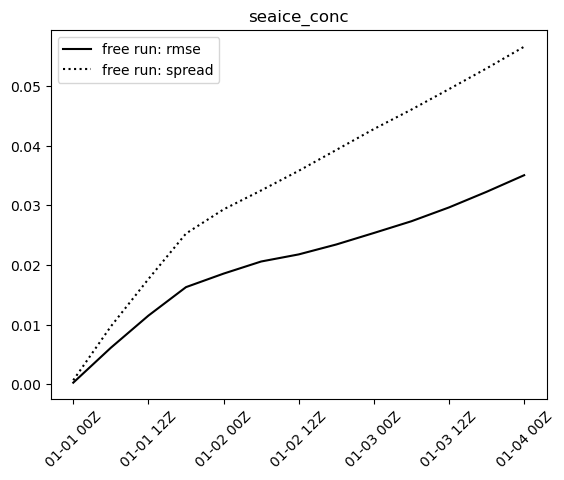

In [17]:
vname = 'seaice_conc'

cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle-free"
ts, rmse_ts, sprd_ts = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts, 'k-', label='free run: rmse')
plt.plot(ts, sprd_ts, 'k:', label='free run: spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HZ'))
plt.legend()
plt.title(vname)
_ = plt.xticks(rotation=45)

## Assimilate single observation

In [ ]:
#obs location
obs_x = 
obs_y = 

obs_seq = 

## Cycling DA

In [ ]:
##rerun cycling experiment from previous free ens run

def run_analysis():
    c.time = c.time_analysis_start
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)

        # don't need to run scheme.preprocess to link files and perturb again
        # only copy the restart files from previous cycle
        for m in range(c.nens):
            file1 = model.filename(path=c.forecast_dir(c.prev_time, 'nextsim.dg'), member=m, time=c.time) 
            file2 = model.filename(path=c.forecast_dir(c.time, 'nextsim.dg'), member=m, time=c.time)
            os.system(f"cp {file1} {file2}")

        # run data assimilation
        scheme.run_step(c, 'filter', mpi=True)

        # postprocess model variables
        scheme.run_step(c, 'postprocess', mpi=False)

        # ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_analysis()

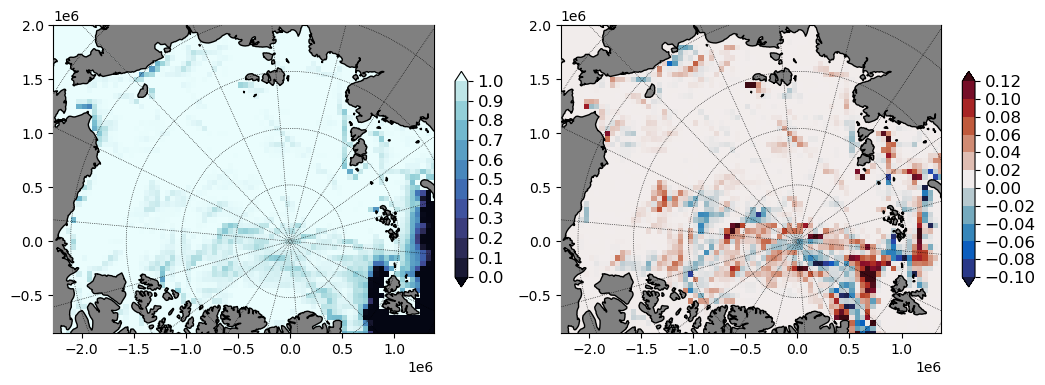

In [32]:
#plot analysis increment
c.time = datetime(2010, 1, 2, 6, tzinfo=timezone.utc)

##which state variable to show?
vname = 'seaice_conc_dg'
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice
vmin_diff = -0.1
vmax_diff = 0.1
cmap_diff = cmocean.cm.balance

##which member?
mem_id = 0

# read from model restart files
path = c.forecast_dir(c.prev_time, 'nextsim.dg')
fld0 = model.read_var(path=path, member=mem_id, time=c.time, name=vname, k=k)
path = c.forecast_dir(c.time, 'nextsim.dg')
fld1 = model.read_var(path=path, member=mem_id, time=c.time, name=vname, k=k)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

c.grid.plot_field(ax[0], fld0[...], vmin, vmax, cmap=cmap)
add_colorbar(fig, ax[0], cmap, vmin, vmax)

c.grid.plot_field(ax[1], (fld1-fld0)[...], vmin_diff, vmax_diff, cmap=cmap_diff)
add_colorbar(fig, ax[1], cmap_diff, vmin_diff, vmax_diff)

for i in range(2):
    c.grid.plot_land(ax[i], color='gray')


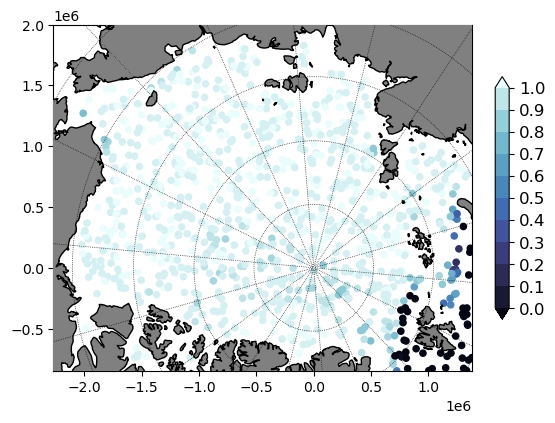

In [33]:
##plot obs network
seq = np.load(os.path.join(c.analysis_dir(c.time), "obs_seq.rec0.npy"), allow_pickle=True).item()

fig, ax = plt.subplots(1, 1, figsize=(6,4.5))

c.grid.plot_scatter(ax, seq['obs'], x=seq['x'], y=seq['y'], vmin=vmin, vmax=vmax, cmap=cmap, markersize=20)
add_colorbar(fig, ax, cmap, vmin, vmax)

c.grid.plot_land(ax, color='gray')


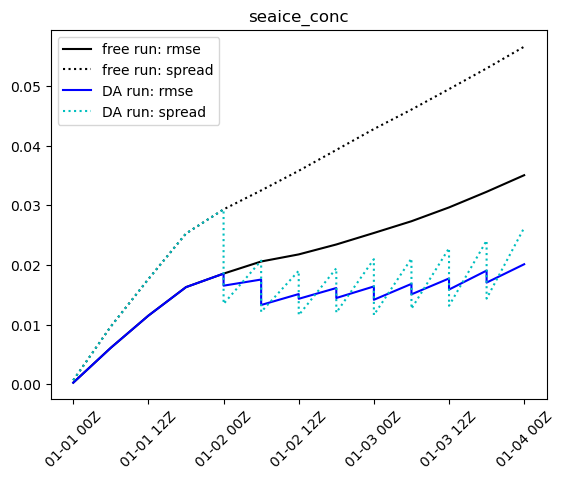

In [18]:
vname = 'seaice_conc'

cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle-free"
ts, rmse_ts, sprd_ts = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts, 'k-', label='free run: rmse')
plt.plot(ts, sprd_ts, 'k:', label='free run: spread')

cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle"
ts, rmse_ts, sprd_ts = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts, 'b-', label='DA run: rmse')
plt.plot(ts, sprd_ts, 'c:', label='DA run: spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HZ'))
plt.legend()
plt.title(vname)
_ = plt.xticks(rotation=45)